# 线性回归策略
*用线性回归交易*

## 目录

- 什么是线性回归?
- Slope和intercept是什么?
- Confidence Band是怎么算的？
- 如何用线性回归做策略?

## 什么是线性回归?
在统计学中，线性回归(Linear Regression)是利用称为线性回归方程的最小平方函数对一个或多个自变量和因变量之间关系进行建模的一种回归分析。

## Slope和intercept是什么?
$y = kx+b$

其中k是slope,而b是intercept

## Confidence Band是怎么算的？
一般是Y加减两个标准差的值

## 如何用线性回归做策略?
1. Buy: 价格大于预测值
2. Buy: 价格大于上方边界
3. Buy: Slope>0
4. Buy: 残差变化率的均线上涨

In [1]:
from jaqs_fxdayu.data import DataView
from jaqs_fxdayu.data import RemoteDataService
import numpy as np
import talib as ta
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")

dataview_folder = '../Factor'
dv = DataView()
dv.load_dataview(dataview_folder)

D:\Anaconda3\lib\importlib\__init__.py:126: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  return _bootstrap._gcd_import(name[level:], package, level)


Dataview loaded successfully.


In [2]:
def change_index(df):
    df.index = pd.Index(map(lambda x: datetime.strptime(str(x),"%Y%m%d") , df.index))
    return df
data = change_index(dv.get_ts('close').loc[20170105:])

In [3]:
# data['000001.SZ']

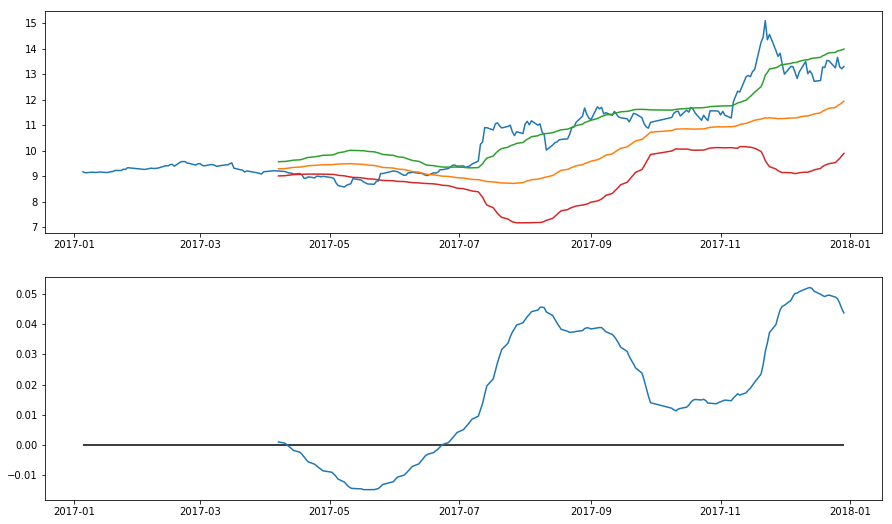

In [4]:
slope = ta.abstract.LINEARREG_SLOPE(data, 60, price='000001.SZ')
intercept = ta.abstract.LINEARREG_INTERCEPT(data, 60, price='000001.SZ')
prediction = slope*data['000001.SZ']+intercept
band = 2*ta.abstract.STDDEV(data, 60, price='000001.SZ')

plt.figure(figsize=(15,9))
plt.subplot(2,1,1)
plt.plot(data['000001.SZ'])
plt.plot(prediction)
plt.plot(prediction+band)
plt.plot(prediction-band)
plt.subplot(2,1,2)
plt.hlines(y=0,xmax=slope.index[-1],xmin=slope.index[0])
plt.plot(slope)
plt.show()

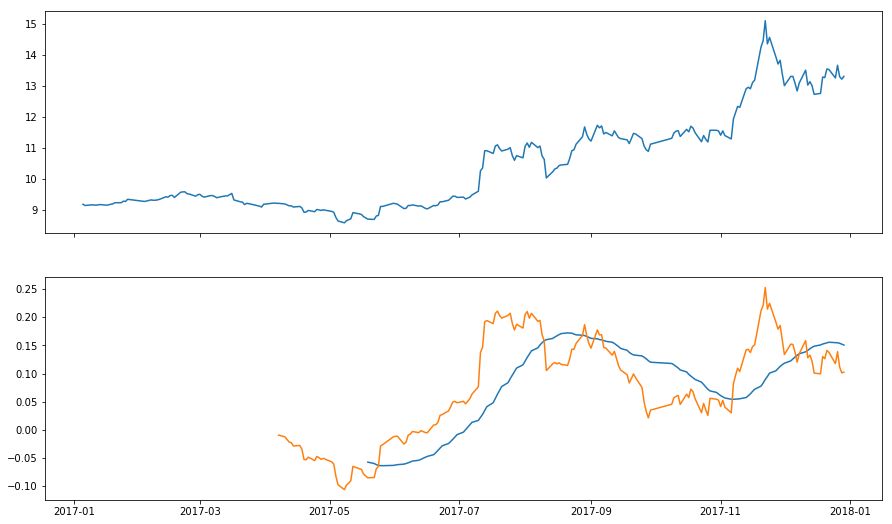

In [5]:
# 残差
residual = (data['000001.SZ']-prediction)/data['000001.SZ']
MA_R = pd.Series(ta.MA(residual.values, 30),index=residual.index)

f,(a1,a2)=plt.subplots(2,1,sharex=True,figsize=(15,9))
a1.plot(data['000001.SZ'])
a2.plot(MA_R)
a2.plot(residual)
plt.show()

In [3]:
# 残差变化率的均线上涨

from __future__ import division
from vnpy.trader.vtConstant import *
from vnpy.trader.app.ctaStrategy.ctaBarManager import (CtaTemplate,
                                                     ArrayManager)
import talib as ta


########################################################################
class LineReg2Strategy(CtaTemplate):
    className = 'LineReg2Strategy'
    author = 'xingetouzi'


    # 策略参数
    LinePeriod = 40
    lots = 1
    stopRatio = 0.08  # 止损比例

    # 策略变量
    maTrend = {}  # 均线趋势，多头1，空头-1
    transactionPrice = {}

    # 参数列表，保存了参数的名称
    paramList = ['className',
                 'author',
                 'symbolList',
                 'LinePeriod',
                 'lots',
                 'stopRatio']

    # 变量列表，保存了变量的名称
    varList = ['transactionPrice',
               'maTrend']

    # 同步列表，保存了需要保存到数据库的变量名称
    syncList = ['posDict', 'eveningDict']

    # ----------------------------------------------------------------------
    def __init__(self, ctaEngine, setting):
        super(LineReg2Strategy, self).__init__(ctaEngine, setting)

    # ----------------------------------------------------------------------
    def onInit(self):
        """初始化策略（必须由用户继承实现）"""
        self.setArrayManagerSize(200)
        self.maTrend = {s: 0 for s in self.symbolList}
        self.transactionPrice = {s: 0 for s in self.symbolList}
        self.putEvent()  # putEvent 能刷新策略UI界面的信息

    # ----------------------------------------------------------------------
    def onStart(self):
        """启动策略（必须由用户继承实现）"""
        self.putEvent()
        '''
        实盘在点击启动策略时, 此时的引擎下单逻辑改为True, 此时开始推送到onbar的数据, 会触发下单。
        '''

    # ----------------------------------------------------------------------
    def onStop(self):
        """停止策略（必须由用户继承实现）"""
        self.putEvent()

    # ----------------------------------------------------------------------
    def onRestore(self):
        """恢复策略（必须由用户继承实现）"""
        # 策略恢复会自动读取 varList 和 syncList 的数据，还原之前运行时的状态。
        # 需要注意的是，使用恢复，策略不会运行 onInit 和 onStart 的代码，直接进入行情接收阶段
        self.putEvent()

    # ----------------------------------------------------------------------
    def onTick(self, tick):
        """收到行情TICK推送（必须由用户继承实现）"""
        # 在每个Tick推送过来的时候,进行updateTick,生成分钟线后推送到onBar.
        # 需要注意的是，如果没有updateTick，实盘将不会推送1分钟K线
        pass

    # ----------------------------------------------------------------------
    def onBar(self, bar):
        """收到Bar推送（必须由用户继承实现）"""
        symbol = bar.vtSymbol
        self.writeCtaLog(u'%s, bar.close%s, %s' % (symbol, bar.close, bar.datetime))  # 可以将实盘的运行情况记录到日志里

        # 持有多头仓位
        if self.posDict[symbol + "_LONG"] > 0:
            if (bar.close < self.transactionPrice[symbol] * (1 - self.stopRatio)) or \
                    (bar.close > self.transactionPrice[symbol] * (1 + 2 * self.stopRatio)):
                self.sell(symbol, bar.close * 0.98, self.posDict[symbol + "_LONG"])

        # 持有空头仓位
        elif self.posDict[symbol + "_SHORT"] > 0:
            if (bar.close > self.transactionPrice[symbol] * (1 + self.stopRatio)) or \
                    (bar.close < self.transactionPrice[symbol] * (1 - 2 * self.stopRatio)):
                self.cover(symbol, bar.close * 1.02, self.posDict[symbol + "_SHORT"])

        self.putEvent()  # 每分钟更新一次UI界面

    def on5MinBar(self, bar):
        """3分钟K线推送"""
        symbol = bar.vtSymbol

        am5 = self.getArrayManager(symbol, "5m")

        if not am5.inited:
            return

        slope = ta.LINEARREG_SLOPE(am5.close, self.LinePeriod)
        intercept = ta.LINEARREG_INTERCEPT(am5.close, self.LinePeriod)
        prediction = slope * am5.close + intercept
        residual = (am5.close - prediction) / am5.close
        residual_MA = ta.MA(residual, 20)

        if residual[-1] > residual_MA[-1]:
            self.maTrend[symbol] = 1
        elif residual[-1] < residual_MA[-1]:
            self.maTrend[symbol] = -1
        else:
            self.maTrend[symbol] = 0

        if self.posDict[symbol + "_LONG"] == 0 and self.posDict[symbol + "_SHORT"] == 0:
            if self.maTrend[symbol] == 1:
                self.buy(symbol, bar.close * 1.02, self.lots)
            if self.maTrend[symbol] == -1:
                self.short(symbol, bar.close * 0.98, self.lots)

    def onOrder(self, order):
        """收到委托变化推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onOrder
        pass

    # ----------------------------------------------------------------------
    def onTrade(self, trade):
        symbol = trade.vtSymbol
        """收到成交推送（必须由用户继承实现）"""
        # 对于无需做细粒度委托控制的策略，可以忽略onTrade
        self.transactionPrice[symbol] = trade.price

    # ----------------------------------------------------------------------
    def onStopOrder(self, so):
        """停止单推送"""
        pass

仓位字典构造完成 
初始仓位: {'BTCUSDT:binance_LONG': 0, 'BTCUSDT:binance_SHORT': 0}
[DEBUG] 注册品种BTCUSDT:binance上的on_1m_bar函数functools.partial(<function LineReg2Strategy.onBar at 0x0000024BE857C598>, <__main__.LineReg2Strategy object at 0x0000024BE86392B0>)
[DEBUG] 注册品种BTCUSDT:binance上的on_5Min_bar函数functools.partial(<function LineReg2Strategy.on5MinBar at 0x0000024BE857CE18>, <__main__.LineReg2Strategy object at 0x0000024BE86392B0>)
2018-11-24 13:25:39.684850	开始回测
2018-11-24 13:25:39.684850	策略初始化
2018-11-24 13:25:39.687850	载入历史数据。数据范围:[20180923 04:00,20181001 12:00)
2018-11-24 13:26:12.092459	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:26:12.109450	载入完成，数据量：12000
2018-11-24 13:26:12.109450	策略初始化完成
2018-11-24 13:26:12.109450	策略启动完成
2018-11-24 13:26:12.109450	开始回放回测数据,回测范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:26:12.117445	载入历史数据。数据范围:[20181001 12:00,20181031 16:00)
2018-11-24 13:26:51.347510	失去MongoDB的连接，我们尝试使用本地缓存数据，请注意数据量
2018-11-24 13:26:51.423491	载入完成，数据量：42270
2018-11-24 13:26:51.424

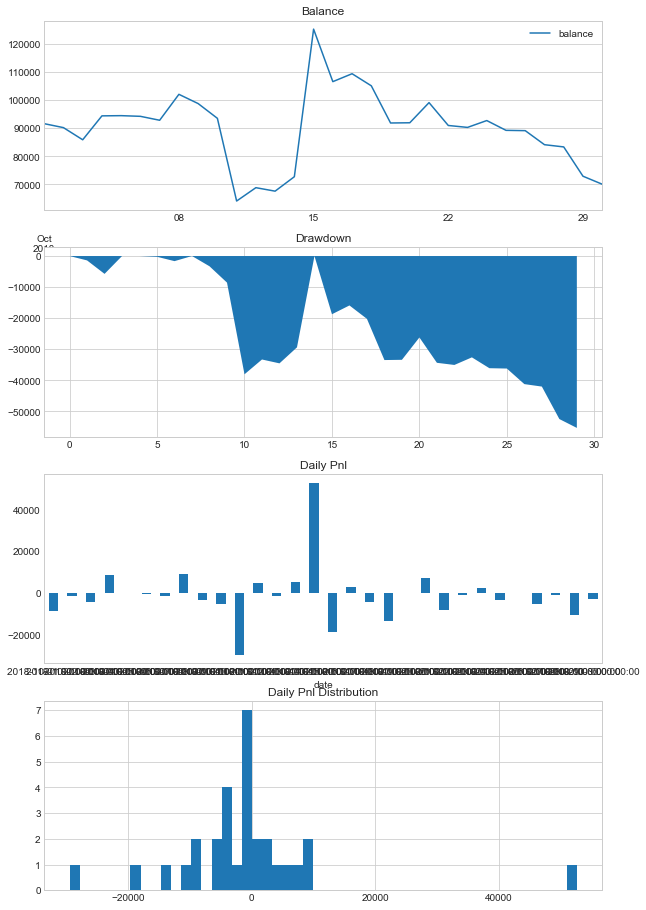

2018-11-24 13:28:07.074525	计算回测结果
2018-11-24 13:28:07.083520	交割单已生成
2018-11-24 13:28:07.083520	------------------------------
2018-11-24 13:28:07.083520	第一笔交易：	2018-10-30 23:58:00
2018-11-24 13:28:07.083520	最后一笔交易：	2018-10-30 23:58:00
2018-11-24 13:28:07.083520	总交易次数：	1
2018-11-24 13:28:07.083520	总盈亏：	-30,255.2
2018-11-24 13:28:07.083520	最大回撤: 	-30,255.2
2018-11-24 13:28:07.084519	平均每笔盈利：	-30,255.2
2018-11-24 13:28:07.084519	平均每笔滑点：	0.0
2018-11-24 13:28:07.084519	平均每笔佣金：	650.2
2018-11-24 13:28:07.084519	胜率		0.0%
2018-11-24 13:28:07.084519	盈利交易平均值	0
2018-11-24 13:28:07.084519	亏损交易平均值	-30,255.2
2018-11-24 13:28:07.084519	盈亏比：	-0.0
2018-11-24 13:28:07.455308	交易记录没有达到10笔！
2018-11-24 13:28:07.456306	计算按日统计结果


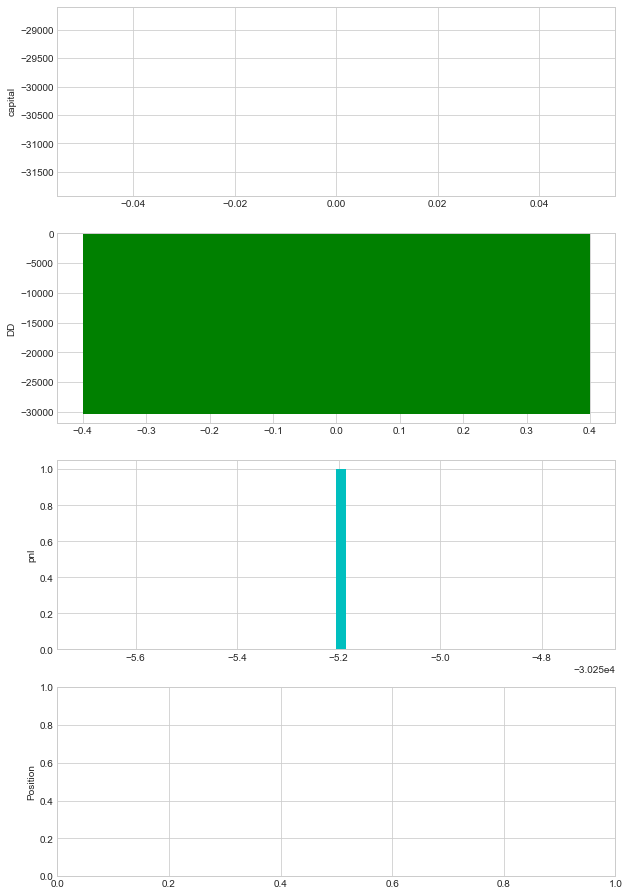

In [4]:
from vnpy.trader.app.ctaStrategy.ctaBarManager import BacktestingEngine
import pandas as pd

def runBacktesting(strategyClass, settingDict,
                   startDate, endDate, size, slippage, rate):
    engine = BacktestingEngine()
    engine.setBacktestingMode(engine.BAR_MODE)  # 设置引擎的回测模式为K线
    engine.setDatabase('VnTrader_1Min_Db')    # 设置使用的历史数据库
    engine.setStartDate(startDate, initHours=200)   # 设置回测用的数据起始日期
    engine.setEndDate(endDate)     # 设置回测用的数据结束日期
    engine.setSize(size)          # 设置合约大小
    engine.setSlippage(slippage)    # 设置滑点
    engine.setRate(rate)             # 设置手续费万0.3
    engine.initStrategy(strategyClass, settingDict)
    engine.setCapital(100000)     # 设置回测本金
    engine.setLog(True, 'E://log//')
    engine.runBacktesting()
    #显示逐日回测结果
    engine.showDailyResult()
    #显示逐笔回测结果
    engine.showBacktestingResult()
    # 计算回测结果
    perfromance = engine.calculateDailyResult()
    perfromanceDf , result = engine.calculateDailyStatistics(perfromance)
    tradeReport = pd.DataFrame([obj.__dict__ for obj in engine.tradeDict.values()])
    tradeDf = tradeReport.set_index('dt')
    return perfromanceDf, tradeDf

if __name__ == '__main__':
    # 同时传入信号与执行的数据
    performanceReport, tradeReport = \
        runBacktesting(LineReg2Strategy, {'symbolList': ['BTCUSDT:binance']},
                       '20181001 12:00', '20181031 16:00', 100, 0, 5/10000)
    # tradeReport.to_excel('LineReg2StrategyReport.xlsx')